# Data Pipeline

This notebook describes the pipeline for milestone 3 for our project. It should give an overview of how we intend to load, clean, parse and exploit our data for our story telling.

## Imports

In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from collections import defaultdict

# Loading and cleaning the data

Given the data size, pandas dataframe will be used.

## Handling data

In [2]:
CHARACTER_DATA_PATH = "../data/character.metadata.tsv"
MOVIE_DATA_PATH = "../data/movie.metadata.tsv"
SUMMARIES_DATA_PATH = "../data/plot_summaries.txt"
NAME_DATA_PATH = "../data/name.clusters.txt"
TYPE_DATA_PATH = "../data/tvtropes.clusters.txt"

## Characters data

In [3]:
CHARACTER_HEADER = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height",
    "Actor_ethnicity",
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character/actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID",
]
character = pd.read_table(CHARACTER_DATA_PATH, header=None, names=CHARACTER_HEADER)

In [4]:
character.describe()

,Wikipedia_movie_ID,Actor_height,Actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


First, we want to clean the dataset :
- negative ages should be removed
- actor's height > 2.5 as well, as they become irrelevant compared to the true height of actors
- dates converted to correct format

In [5]:
character["Actor_age_at_movie_release"] = character["Actor_age_at_movie_release"].apply(
    lambda x: np.nan if x < 0 else x
)
character["Actor_height"] = character["Actor_height"].apply(
    lambda x: np.nan if x > 2.5 else x
)
character["Movie_release_date"] = pd.to_datetime(
    character["Movie_release_date"], format="mixed", utc=True, errors="coerce"
)
character["Actor_date_of_birth"] = pd.to_datetime(
    character["Actor_date_of_birth"], format="mixed", utc=True, errors="coerce"
)
character.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
167953,33434134,/m/0h96c0y,2002-04-20 00:00:00+00:00,NaN,1964-10-05 00:00:00+00:00,M,NaN,NaN,Keiji Fujiwara,37.0,/m/0h9d326,NaN,/m/04b_4y
437647,2165590,/m/06rqj9,1962-01-01 00:00:00+00:00,NaN,NaT,M,NaN,NaN,Michael Kane,NaN,/m/0k0442,NaN,/m/0k043b
438237,29829978,/m/0fq36_x,1990-01-01 00:00:00+00:00,NaN,1935-12-08 00:00:00+00:00,M,1.78,NaN,Dharmendra Deol,54.0,/m/0fq47mm,NaN,/m/02n1gr
358455,2005355,/m/06dfq2,1998-07-24 00:00:00+00:00,Steve Clark,1973-09-18 00:00:00+00:00,M,1.79,NaN,James Marsden,24.0,/m/02vd1sw,/m/0h162v_,/m/042ly5
433107,14114547,/m/03cv1v2,1926-10-14 00:00:00+00:00,NaN,1891-12-16 00:00:00+00:00,M,NaN,NaN,Clyde Cooke,NaN,/m/0cgnmjj,NaN,/m/0ksdcb


## TODO
Should modify the ethnicityto give corresponding freebase ID. https://pypi.org/project/freebase/

### Movies data

In [6]:
MOVIE_HEADER = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages",
    "Movie_countries",
    "Movie_genres",
]

movie = pd.read_table(MOVIE_DATA_PATH, header=None, names=MOVIE_HEADER)

In [7]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


The next cell will transform the dictionaries we might find in the cells of our data frames into comma-separated strings.

In [8]:
def format_dict(x):
    n = len(x)
    if n == 0:
        return np.nan
    else:
        return list(x.values())


try:
    movie["Movie_genres"] = movie["Movie_genres"].apply(json.loads).apply(format_dict)
    movie["Movie_countries"] = (
        movie["Movie_countries"].apply(json.loads).apply(format_dict)
    )
    movie["Movie_languages"] = (
        movie["Movie_languages"].apply(json.loads).apply(format_dict)
    )
except TypeError:
    print("Data has already been parsed and modified.")

There is a bit of cleaning to perform :
- we will focus on movies whose runtime is < 15000, because that is the longest movie we found to have its true length.
- dates to correct format

In [9]:
movie["Movie_runtime"] = movie["Movie_runtime"].apply(
    lambda x: np.nan if 1 > x or x > 15000 else x
)
movie["Movie_release_date"] = pd.to_datetime(
    movie["Movie_release_date"], format="mixed", utc=True, errors="coerce"
)
movie.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
6176,9307577,/m/0283xwr,The Report,NaT,NaN,112.0,[Persian Language],[Iran],[Drama]
26569,32943445,/m/0h53b31,Rip Van Winkle,1912-01-01 00:00:00+00:00,NaN,NaN,[Silent film],NaN,[Silent film]
68686,32169153,/m/0gx_0rq,Face 2 Face,2012-06-05 00:00:00+00:00,NaN,110.0,[English Language],[United States of America],[Documentary]
69193,4616833,/m/0ccw9s,Ernest in the Army,1998-01-02 00:00:00+00:00,NaN,90.0,[English Language],[United States of America],"[Parody, Family Film, Comedy, Slapstick]"
44698,26118288,/m/0b6h1xj,A Gentleman After Dark,1942-04-16 00:00:00+00:00,NaN,74.0,[English Language],[United States of America],"[Crime Fiction, Drama]"


In [10]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,61233.000000
mean,1.740784e+07,4.799363e+07,94.298795
std,1.098791e+07,1.121753e+08,91.294848
min,3.300000e+02,1.000000e+04,1.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,14400.000000


## Summaries data

In [11]:
summaries = pd.read_table(
    SUMMARIES_DATA_PATH, header=None, names=["Wikipedia_movie_ID", "Summary"]
)
summaries.head()

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Character names data

In [12]:
name = pd.read_table(
    NAME_DATA_PATH,
    header=None,
    names=["Character_name", "Freebase_character/actor_map_ID"],
)
name.head()

,Character_name,Freebase_character/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


## Character types data

In [13]:
character_type = pd.read_table(
    TYPE_DATA_PATH, header=None, names=["Character_type", "Instance"]
)
character_type = pd.concat(
    [character_type, character_type["Instance"].apply(json.loads).apply(pd.Series)],
    axis=1,
)
character_type.drop(columns="Instance", inplace=True)
character_type.rename(
    columns={
        "char": "Character_name",
        "movie": "Movie_name",
        "id": "Freebase_character/actor_map_ID",
        "actor": "Actor_name",
    },
    inplace=True,
)
character_type.head()

,Character_type,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


# Data processing pipeline and story telling

The purpose of the data gathering is to tell a story. 

## Genres analysis

First, to analys the genres with have to summarize the 363 different genres that with have in the `Movie_genres` column of the `movie` dataframe.

A naive approach would be to direct do a clustering as below.

/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/2231484949.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2652761636797358' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  co_occurrence_matrix_naive.at[i, j] = co_occurrence_matrix_naive.at[i, j] / min(
/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/2231484949.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.644420558921243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  co_occurrence_matrix_naive.at[i, j] = co_occurrence_matrix_naive.at[i, j] / min(
/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/2231484949.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3784913129535958

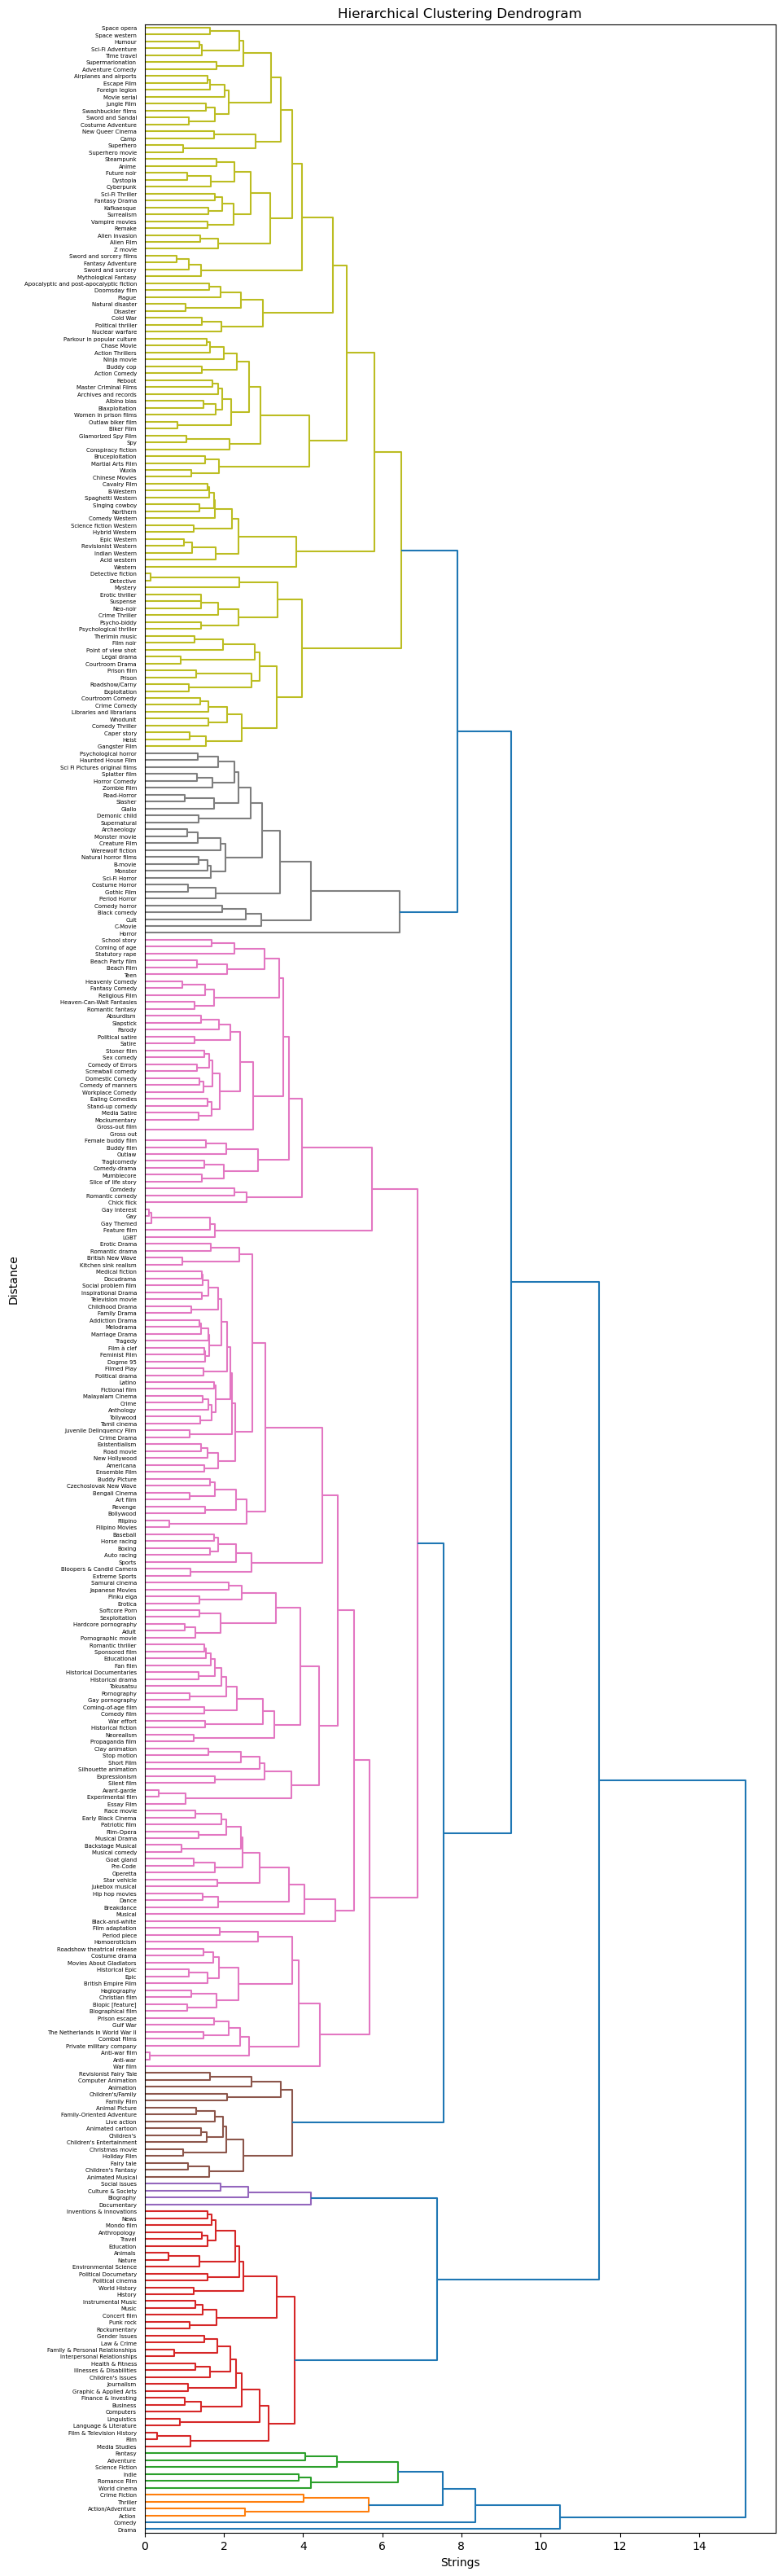

In [14]:
total_occurences_naive = (
    movie["Movie_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
co_occurrence_matrix_naive = pd.DataFrame(
    0, columns=total_occurences_naive.index, index=total_occurences_naive.index
)

# Fill in the co-occurrence matrix
for sublist in movie["Movie_genres"].dropna():
    for i in range(len(sublist)):
        co_occurrence_matrix_naive.at[sublist[i], sublist[i]] += 1
        for j in range(i + 1, len(sublist)):
            string1, string2 = sublist[i], sublist[j]
            co_occurrence_matrix_naive.at[string1, string2] += 1
            co_occurrence_matrix_naive.at[string2, string1] += 1

for i in total_occurences_naive.index:
    for j in total_occurences_naive.index:
        co_occurrence_matrix_naive.at[i, j] = co_occurrence_matrix_naive.at[i, j] / min(
            total_occurences_naive[i], total_occurences_naive[j]
        )

linkage_matrix_naive = linkage(co_occurrence_matrix_naive, method="ward")

plt.figure(figsize=(10, 40))
dendrogram(
    linkage_matrix_naive,
    labels=co_occurrence_matrix_naive.index,
    orientation="right",
    color_threshold=7,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show()

We clearly see that this clustering is not doing ia good job, for exemple for the comedy movies where athe different kind of comedies are not gathered together.

### Genres cleaning

We filter the genres by not taking into account the genres with less than 500 movies (1) and by gathering the other into 30 custom main genres thanks to the `clean_genres` function and `categorized_genres` mapping dictionnary available in the `src/genres_analysis.py` file. 

NB: This mapping dictionnary has been set such that one initial genres may split in two custom main genres, for exemple "Romantic Comedy" will appear in "Romance" and "Comedy"

(1) As shown below, omit these genres does not really affect the number of movies withe genre(s) (at least one)

In [15]:
from genres_analysis import clean_genres, CATEGORIZED_GENRES

movie["Movie_clean_genres"] = (
    movie["Movie_genres"].dropna().apply(lambda x: clean_genres(x, CATEGORIZED_GENRES))
)

In [16]:
len(movie["Movie_clean_genres"].dropna())

78715

In [17]:
len(movie["Movie_genres"].dropna())

79447

The number of film with clean genres is not significantly lower than the number of film with initial genres. Therefore the `categorized_genres` mapping dictionnary did great.

### Genres clustering

/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/3120210007.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.29666867441968214' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  co_occurrence_matrix.at[i, j] = co_occurrence_matrix.at[i, j] / min(
/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/3120210007.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4994153756211634' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  co_occurrence_matrix.at[i, j] = co_occurrence_matrix.at[i, j] / min(
/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/3120210007.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.366743648960739' has dtype incompatibl

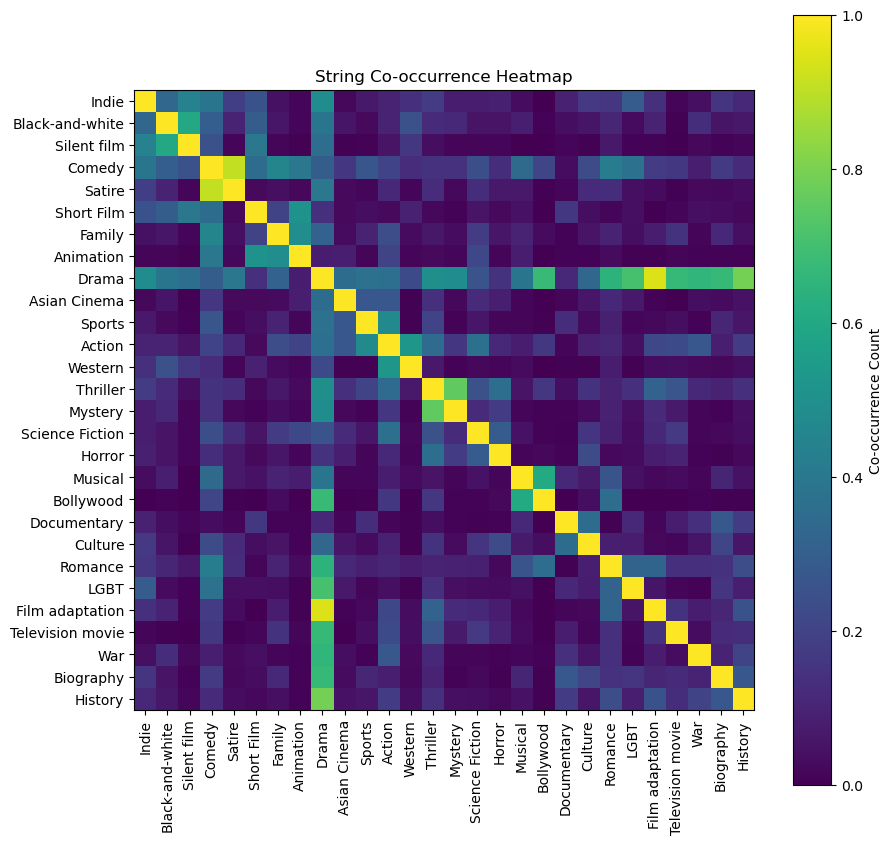

In [18]:
total_occurences = (
    movie["Movie_clean_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
co_occurrence_matrix = pd.DataFrame(
    0, columns=total_occurences.index, index=total_occurences.index
)

# Fill in the co-occurrence matrix
for sublist in movie["Movie_clean_genres"].dropna():
    for i in range(len(sublist)):
        co_occurrence_matrix.at[sublist[i], sublist[i]] += 1
        for j in range(i + 1, len(sublist)):
            string1, string2 = sublist[i], sublist[j]
            co_occurrence_matrix.at[string1, string2] += 1
            co_occurrence_matrix.at[string2, string1] += 1

for i in total_occurences.index:
    for j in total_occurences.index:
        co_occurrence_matrix.at[i, j] = co_occurrence_matrix.at[i, j] / min(
            total_occurences[i], total_occurences[j]
        )

linkage_matrix = linkage(co_occurrence_matrix, method="ward")
co_occurrence_matrix_sorted = co_occurrence_matrix.loc[
    co_occurrence_matrix.index[
        dendrogram(linkage_matrix, orientation="right", no_plot=True)["leaves"]
    ],
    :,
]
co_occurrence_matrix_sorted = co_occurrence_matrix_sorted[
    co_occurrence_matrix_sorted.columns[
        dendrogram(linkage_matrix, orientation="bottom", no_plot=True)["leaves"]
    ]
]
co_occurrence_matrix_sorted.values

plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix_sorted.values, cmap="viridis", interpolation="none")
plt.colorbar(label="Co-occurrence Count")
plt.xticks(
    np.arange(len(total_occurences.index)),
    co_occurrence_matrix_sorted.index,
    rotation=90,
)
plt.yticks(np.arange(len(total_occurences.index)), co_occurrence_matrix_sorted.index)
plt.title("String Co-occurrence Heatmap")
plt.show()

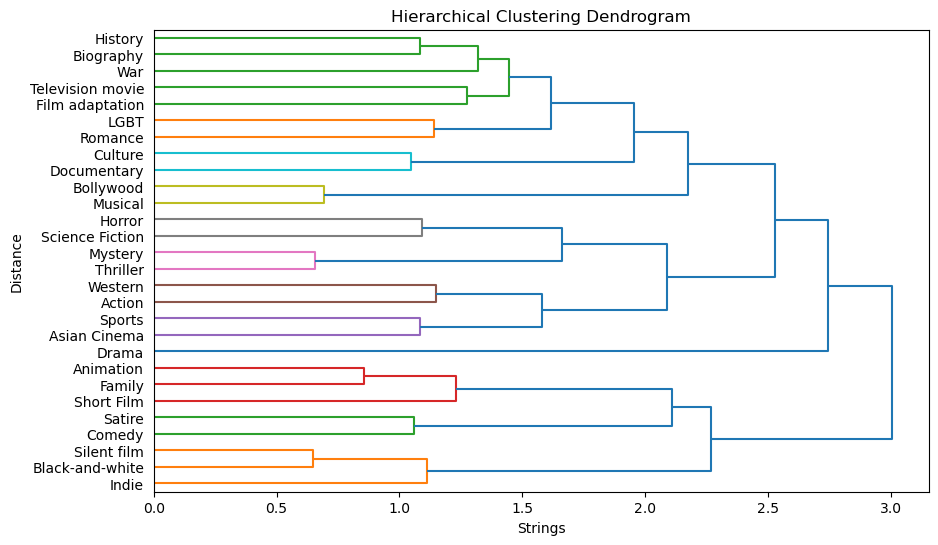

In [19]:
# Plot the dendrogram to visualize hierarchical clustering
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    labels=co_occurrence_matrix.index,
    orientation="right",
    color_threshold=1.5,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show();

In [20]:
clusters = fcluster(linkage_matrix, t=1.5, criterion="distance")

In [21]:
# Create a dict to map cluster labels to total_occurences indices
cluster_dict = defaultdict(list)

for i, cluster_number in enumerate(clusters):
    cluster_dict[cluster_number].append(total_occurences.index[i])

cluster_dict = dict(cluster_dict)

print(cluster_dict)

{12: ['Drama'], 2: ['Comedy', 'Satire'], 6: ['Thriller', 'Mystery'], 5: ['Action', 'Western'], 10: ['Romance', 'LGBT'], 1: ['Black-and-white', 'Indie', 'Silent film'], 3: ['Short Film', 'Family', 'Animation'], 9: ['Documentary', 'Culture'], 7: ['Science Fiction', 'Horror'], 8: ['Musical', 'Bollywood'], 4: ['Asian Cinema', 'Sports'], 11: ['Biography', 'History', 'War', 'Film adaptation', 'Television movie']}


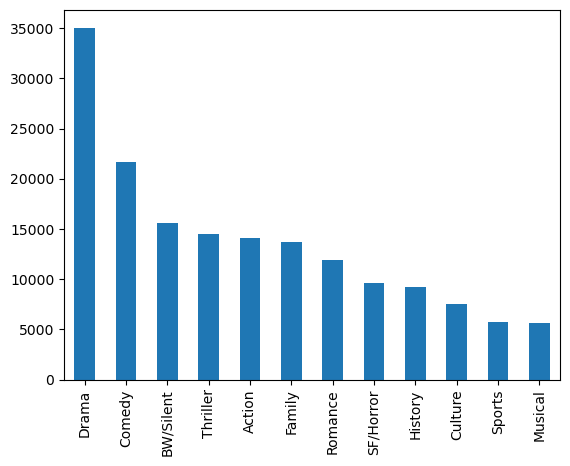

In [22]:
cluster_keys = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "BW/Silent",
    "Family",
    "Culture",
    "SF/Horror",
    "Musical",
    "Sports",
    "History",
]
genres_dict = dict(zip(cluster_keys, list(cluster_dict.values())))

movie["Movie_main_genres"] = (
    movie["Movie_clean_genres"].dropna().apply(lambda x: clean_genres(x, genres_dict))
)

main_genre_occ = (
    movie["Movie_main_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)

main_genre_occ.plot(kind="bar");

In [23]:
def sorted_main_genres(item):
    return list(main_genre_occ.index).index(item)


# In order to have the main genre, the second genre, etc...
movie["Movie_main_genres"] = (
    movie["Movie_main_genres"]
    .dropna()
    .apply(lambda x: sorted(x, key=sorted_main_genres))
)

In [24]:
character_modified = character[
    ["Actor_name", "Actor_gender", "Actor_age_at_movie_release", "Freebase_movie_ID"]
].dropna(subset=["Actor_age_at_movie_release", "Actor_name", "Actor_gender"])

In [25]:
character_movie = character_modified.merge(
    movie[["Freebase_movie_ID", "Movie_main_genres"]].dropna(),
    how="inner",
    on="Freebase_movie_ID",
).drop("Freebase_movie_ID", axis=1)

In [26]:
def category_to_vector(categories):
    vector = [1 if cat in categories else 0 for cat in cluster_keys]
    return np.array(vector)


character_movie["Vector_genres"] = character_movie["Movie_main_genres"].apply(
    category_to_vector
)

In [27]:
character_movie.sort_values("Actor_age_at_movie_release", inplace=True)

In [28]:
character_movie

,Actor_name,Actor_gender,Actor_age_at_movie_release,Movie_main_genres,Vector_genres
15739,Robert Stanton,M,0.0,"[BW/Silent, SF/Horror]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
125790,Heather Henson,F,0.0,"[Family, SF/Horror, History, Musical]","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]"
139907,Chris O'Neil,M,0.0,"[Drama, BW/Silent, History, Musical]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]"
250918,Jamuna,F,0.0,"[BW/Silent, Musical]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
90585,Sofia Coppola,F,0.0,"[Drama, Thriller, History]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...
240607,Leni Riefenstahl,F,97.0,[Culture],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
25926,Renée Saint-Cyr,F,99.0,"[History, Culture]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
8923,Philip Johnson,M,99.0,"[BW/Silent, History, Culture]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
258712,Mel Blanc,M,103.0,[Family],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


In [29]:
actor_age_vector = character_movie.groupby(
    ["Actor_name", "Actor_gender", "Actor_age_at_movie_release"]
).agg(Yearly_vector=("Vector_genres", np.mean))

/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/506173698.py:1: FutureWarning: The provided callable <function mean at 0x7fbd1e64a430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  actor_age_vector = character_movie.groupby(


In [30]:
actor_age_vector = (
    actor_age_vector.groupby(level=0)
    .filter(lambda x: len(x) >= 10)
    .reset_index(level="Actor_age_at_movie_release")
)
actor_age_vector = actor_age_vector.groupby(["Actor_name", "Actor_gender"])

In [57]:
print("The number of actors who played at 10 different ages during their career is {} whereas the number of actors with genre, ages and gender given is {}.".format(len(actor_age_vector.indices.keys()),len(character_movie.Actor_name.unique())))

The number of actors who played at 10 different ages during their career is 5407 whereas the number of actors with genre, ages and gender given is 50216.


In [32]:
from scipy.spatial import distance


# Function to compute shift significance for each age within an actor group
def compute_shift_significance_age(group, prev_years, future_years):
    significance_values = []

    for i in range(len(group)):
        current_age = group.iloc[i]["Actor_age_at_movie_release"]
        current_vector = group.iloc[i].drop("Actor_age_at_movie_release").values[0]

        # Calculate shift significance for the current age
        prev_age_data = group[
            (group["Actor_age_at_movie_release"] < current_age)
            & (group["Actor_age_at_movie_release"] >= current_age - prev_years)
        ]
        future_age_data = group[
            (group["Actor_age_at_movie_release"] > current_age)
            & (group["Actor_age_at_movie_release"] <= current_age + future_years)
        ]

        if len(prev_age_data) > 0 and len(future_age_data) > 0:
            prev_distances = [
                distance.cosine(current_vector, vec[0])
                for vec in prev_age_data.drop(
                    "Actor_age_at_movie_release", axis=1
                ).values
            ]
            avg_prev_distance = np.mean(prev_distances)
            std_prev_distance = np.std(prev_distances)

            future_distances = [
                distance.cosine(current_vector, vec[0])
                for vec in future_age_data.drop(
                    "Actor_age_at_movie_release", axis=1
                ).values
            ]
            std_future_distance = np.std(future_distances)

            significance = avg_prev_distance / (
                1 + std_future_distance * std_prev_distance
            )
            # significance = np.std(prev_distances+future_distances)
            significance_values.append((current_age, significance))

    return pd.DataFrame(
        significance_values,
        columns=["Actor_age_at_movie_release", "Shift_Significance"],
    ).set_index("Actor_age_at_movie_release")


# Parameters for number of previous and future ages to consider
prev_years = 3  # Number of previous ages to consider
future_years = 3  # Number of future ages to consider

# Apply the function to calculate shift significance for each actor and age
result = actor_age_vector.apply(
    lambda group: compute_shift_significance_age(group, prev_years, future_years)
)

/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/136476119.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  result = actor_age_vector.apply(
/var/folders/cr/d3xnpx2j35362j435xz856fw0000gn/T/ipykernel_10153/136476119.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = actor_age_vector.apply(


In [33]:
result

Shift_Significance
Actor_name    Actor_gender Actor_age_at_movie_release                    
A. J. Cook    F            20.0                                  0.591752
                           21.0                                  0.350198
                           22.0                                  1.000000
                           23.0                                  1.000000
                           24.0                                  0.578420
...                                                                   ...
Željko Ivanek M            44.0                                  0.399645
                           45.0                                  0.407220
                           46.0                                  0.288945
                           47.0                                  0.417812
                           49.0                                  0.403739

[63253 rows x 1 columns]

In [34]:
test = character_movie["Actor_name"].value_counts() >= 10
test[test.values].index

Index(['Mel Blanc', 'Mithun Chakraborty', 'Mohanlal', 'Dharmendra Deol',
       'Mammootty', 'Amitabh Bachchan', 'Larry Fine', 'Brahmanandam',
       'Prakash Raj', 'Frank Welker',
       ...
       'Myles Jeffrey', 'Cameron Bancroft', 'Charlie Watts',
       'Kristen Johnston', 'Gloria Jean', 'Rajshree', 'Anita Garvin',
       'Rajeshwari Sachdev', 'Charlie Hunnam', 'Carol White'],
      dtype='object', name='Actor_name', length=7551)

In [35]:
result_formated = result.reset_index(
    level=["Actor_age_at_movie_release", "Actor_gender"]
)

In [36]:
def actor_genre_year(actor):
    result = []
    for index, row in character_movie[character_movie["Actor_name"] == actor][
        ["Movie_main_genres", "Actor_age_at_movie_release"]
    ].iterrows():
        sublist = row["Movie_main_genres"]
        for genre in sublist:
            result.append((genre, row["Actor_age_at_movie_release"]))
    return pd.DataFrame(result, columns=["genre", "age"])

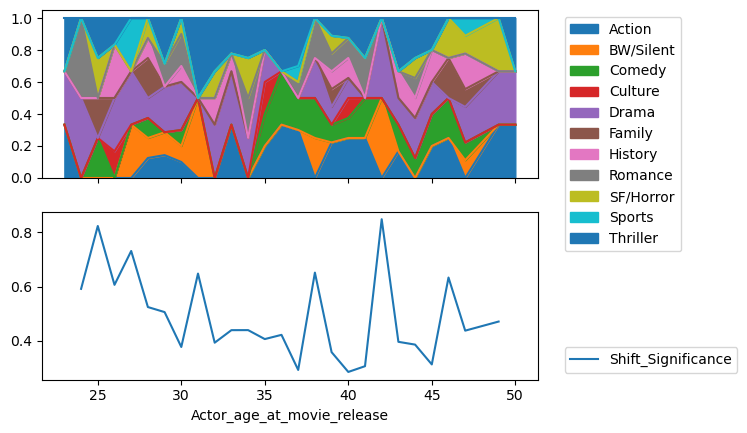

In [37]:
actor = "Brad Pitt"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
actor_genre_year(actor).groupby(["age", "genre"]).size().unstack(fill_value=0).apply(
    lambda row: row / sum(row), axis=1
).plot.area(stacked=True, ax=ax1)
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
result_formated[result_formated.index == actor].plot(
    x="Actor_age_at_movie_release", y="Shift_Significance", ax=ax2
)
ax2.legend(bbox_to_anchor=(1.04, 0), loc="lower left");

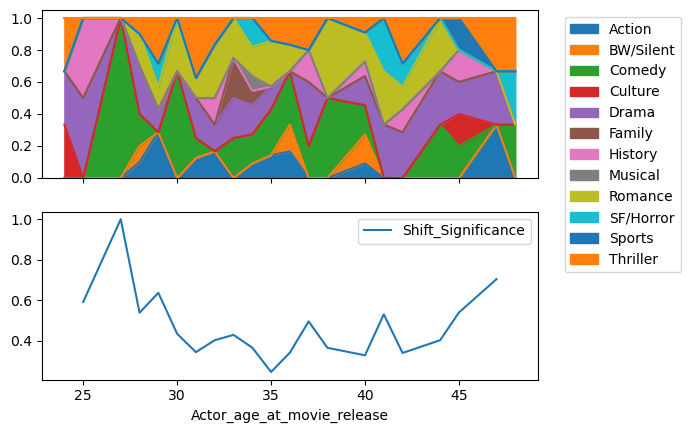

In [38]:
actor = "Sandra Bullock"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True  )
actor_genre_year(actor).groupby(["age", "genre"]).size().unstack(fill_value=0).apply(
    lambda row: row / sum(row), axis=1
).plot.area(stacked=True, ax=ax1)
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
result_formated[result_formated.index == actor].plot(
    x="Actor_age_at_movie_release", y="Shift_Significance", ax=ax2
)
ax2.legend();

In [39]:
result_M = (
    result[result.index.get_level_values(1) == "M"]
    .groupby("Actor_age_at_movie_release")["Shift_Significance"]
    .mean()
)
result_F = (
    result[result.index.get_level_values(1) == "F"]
    .groupby("Actor_age_at_movie_release")["Shift_Significance"]
    .mean()
)

Text(0.5, 0, 'Shift significance')

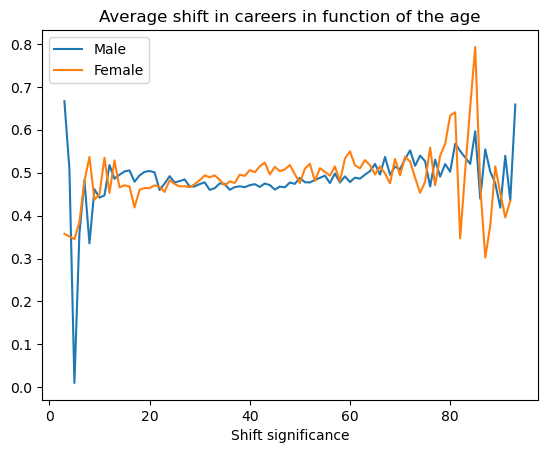

In [40]:
plt.plot(result_M.index, result_M.values, label="Male")
plt.plot(result_F.index, result_F.values, label="Female")
plt.legend()
plt.title('Average shift in careers in function of the age')
plt.xlabel('Age')
plt.xlabel('Shift significance')